# ATOC5860 - response_function_moving_avg_convolve_acs - Lecture #12
### Coded by Prof. Barnes (CSU), additional commenting/updating by Prof. Kay (CU)
### works with python environment atoc5860env2023clean
### Last updated April 5, 2023

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio

## Smoothing of the original data in the time domain

Note: Is the red 1x smoothed supposed to be off center? yes!  

When you only filter forward... you lose data at the end of the time series.


## Create synthetic data

Create an array of integers from 1 to 39 for the time variable, $t$.

Create an array of zeros for the variable $x$ which will be modified further to create our original signal.

In [2]:
t = np.arange(1,40)
x = np.zeros(np.shape(t))

Replace the middle two zeros in $x$ with ones.

In [3]:
foo=round(np.size(t)/2)
foo1=round(foo+2)
x[foo:foo1] = np.ones((2,))

## You can try different response functions here.... (where g is the response function)

In [4]:
#g = [1.,2.,1.] ## 1-2-1
g = [1.,1.,1.] ## run mean 3 (1-1-1)
#g = [1.,1., 1., 1.,1.] ## run mean 5
#g = [1., 1.,1., 1., 1.,1.,1.] ## run mean 7

### Testing a forward filter and a forward/backward filter

Now use a forward filter function called [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) which filters (smooths) data along one-dimension. Source code for the filter can be download from [this github link](https://github.com/scipy/scipy/blob/v1.5.4/scipy/signal/signaltools.py#L1719-L1909).

Also test a Forward/backward filter called [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html#scipy.signal.filtfilt) which applies a linear digital filter twice, once forward and once backwards. Source code for this filter can be downloaded from [this github link](https://github.com/scipy/scipy/blob/v1.5.4/scipy/signal/signaltools.py#L3724-L3922).

### Filter in the time domain: apply 1-1-1 smoothing



In [5]:
y1 = sig.lfilter(g,np.sum(g),x)

### Filter in the time domain: apply 1-1-1 smoothing twice (forward/backward)

Use padding to pad the data at either end before convolving the response function with the time series. 

### Notes on padding
When method is “pad”, the function pads the data along the given axis in one of three ways: odd, even or constant. The odd and even extensions have the corresponding symmetry about the end point of the data. The constant extension extends the data with the values at the end points. On both the forward and backward passes, the initial condition of the filter is found by using lfilter_zi and scaling it by the end point of the extended data.

When method is “gust”, Gustafsson’s method [1] is used. Initial conditions are chosen for the forward and backward passes so that the forward-backward filter gives the same result as the backward-forward filter.

In [6]:
y2 = sig.filtfilt(g,np.sum(g),x, padtype=None, padlen=0, method='pad')

In [7]:
print(x.shape)
print(y1.shape)
print(y2.shape)

(39,)
(39,)
(39,)


## Make a plot of the original x variable and the two filtered versions of x which are y1 and y2

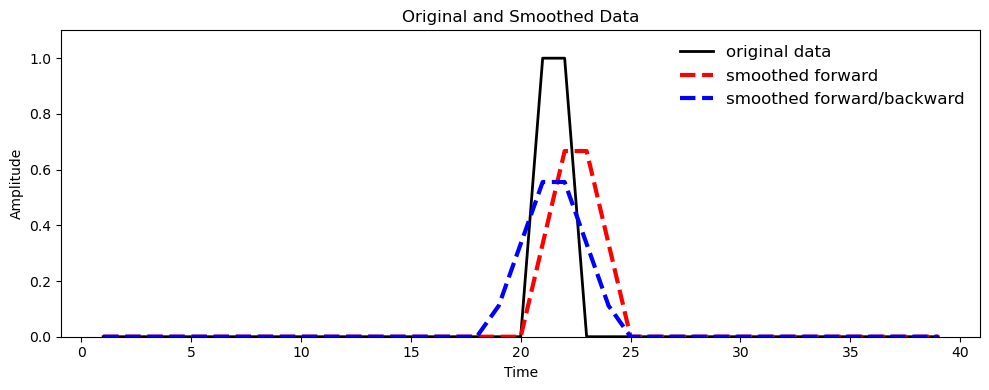

In [8]:
f=plt.figure(figsize=(10,4))
plt.title('Original and Smoothed Data');
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(t,x,'-k',linewidth = 2, label ='original data');
plt.plot(t,y1,'--r',linewidth = 3, label = 'smoothed forward' );
plt.plot(t,y2,'--b',linewidth = 3, label = 'smoothed forward/backward' );
plt.ylim(0,1.1);
plt.legend(fontsize = 12, frameon = False, loc='upper right');
f.tight_layout()

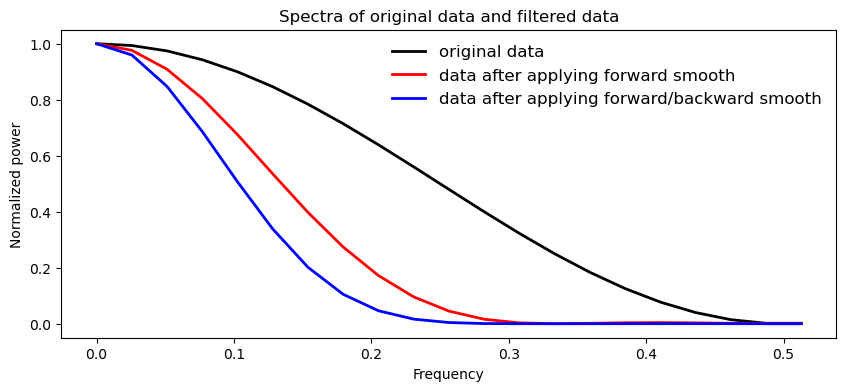

In [9]:
## Calculate the power spectra of original and filtered data
Z_x = np.fft.fft(x)/np.size(x)
Z_y1 = np.fft.fft(y1)/np.size(y1)
Z_y2 = np.fft.fft(y2)/np.size(y2)

Ck2_x = np.abs(Z_x[0:round(np.size(Z_x)/2) + 1])**2
Ck2_y1 = np.abs(Z_y1[0:round(np.size(Z_x)/2) + 1])**2
Ck2_y2 = np.abs(Z_y2[0:round(np.size(Z_x)/2) + 1])**2

freq = np.arange(0,np.size(x)/2+1)/float(np.size(x))

### Plot power spectra of the data and filtered data

f=plt.figure(figsize=(10,4))
plt.title('Spectra of original data and filtered data');
maxval = np.max(Ck2_x)
plt.plot(freq,Ck2_x/maxval,'-k',linewidth = 2, label = 'original data');
maxval = np.max(Ck2_y1)
plt.plot(freq,Ck2_y1/maxval,'-r',linewidth = 2, label = 'data after applying forward smooth');
maxval = np.max(Ck2_y2)
plt.plot(freq,Ck2_y2/maxval,'-b',linewidth = 2, label = 'data after applying forward/backward smooth');
plt.legend(fontsize = 12, frameon = False, loc='upper right');
plt.xlabel('Frequency');
plt.ylabel('Normalized power');

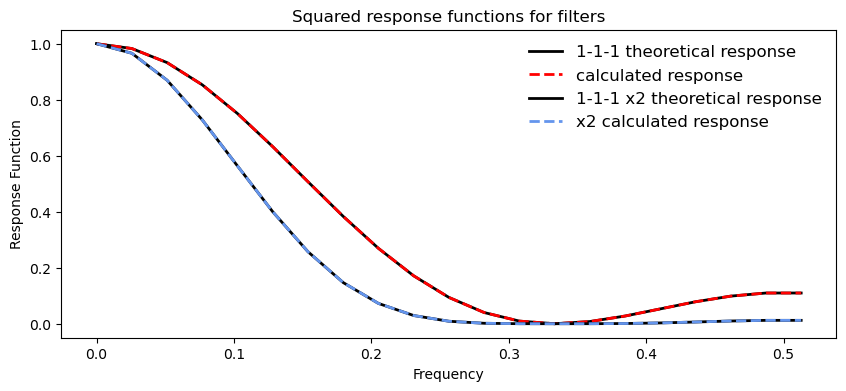

In [10]:
## Find the response function of the filters -- Barnes Equations 94-96
freq = np.arange(0,round(np.size(Z_x)/2)+1)/float(np.size(x))

## Theoretical Response Function 1-2-1  ## Barnes Eq. 108 page 26 Chapter 4
#Rg_y1 = 1./2 + (1./2)*np.cos(freq*2.*np.pi)
#Rg_y2 = (1./2 + (1./2)*np.cos(freq*2*np.pi))**2
#label1 = '1-2-1 theoretical response'
#label2 = 'x2 1-2-1 theoretical response'

## Theoretical Response Function 1-1-1
Rg_y1 = 1./3 + (2./3)*np.cos(freq*2.*np.pi)  ## Barnes Eq. 100 page 26 Chapter 4
Rg_y2 = (1./3 + (2./3)*np.cos(freq*2*np.pi))**2
label1 = '1-1-1 theoretical response'
label2 = '1-1-1 x2 theoretical response'

### Response Function
Rg2_y1 = Rg_y1**2
Rg2_y2 = Rg_y2**2

### Plot the response functions squared (to compare with directly with power C_k^2)
f=plt.figure(figsize=(10,4))
plt.title('Squared response functions for filters');
plt.plot(freq,Rg2_y1,'-k',linewidth = 2, label = label1);
plt.plot(freq,Ck2_y1/Ck2_x,'--r',linewidth = 2, label = 'calculated response');
plt.plot(freq,Rg2_y2,'-k',linewidth = 2, label = label2);
plt.plot(freq,Ck2_y2/Ck2_x,'--',color = 'cornflowerblue',linewidth = 2, label = 'x2 calculated response');
plt.legend(fontsize = 12, frameon = False,loc='upper right');
plt.ylabel('Response Function');
plt.xlabel('Frequency');